This notebook constructs a XGBoost pairwise ranking model. It is trained on grouped portmanteaus. These groups are constructed based on the root words of the portmanteaus. Portmanteaus constructed from the same rootwords are thus in the same group.

The XGBoost model is trained on data obtained from the Wikipedia dataset as well as 5 different portmanteaus as generated by the Charmanteau algorithm.


Afterwards, the trained model is evaluated on the test set of the Charmanteau data as well as a corresponding test set constructed by the simple portmanteau generation algorithm.


In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
import xgboost as xgb
from xgboost import DMatrix,train
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Part 1: Setting up the data

In [2]:
def read_into_panda(file):
    data = []
    with open(file) as json_file:
        all_data = json.load(json_file)
    for p in all_data['learning']:
        data.append(p)
    
    panda = pd.DataFrame.from_dict(data)
    return panda, data

def read_into_panda_lowercase(file):
    data = []
    with open(file) as json_file:
            all_data = json.load(json_file)
    for p in all_data['learning']:
            p['result'] = p['result'].lower()
            data.append(p)
    panda = pd.DataFrame.from_dict(data)
    return panda, data

In [3]:
def construct_groups_charmanteau(file, number_portmanteaus):
    panda, data = read_into_panda(file)
    
    k = -1
    cur_1 = None
    cur_2 = None
    groups = []
    g = 0
    correctly_predicted = np.zeros((number_portmanteaus,), dtype=int)
    predicted = True

    for i in range(len(data)):
        if cur_1 == data[i]['root1'] and cur_2 == data[i]['root2']:
            if data[i]['prediction_place'] == 0:
                predicted = False
            data[i]['group'] = k
            g = g+1
        else:
            if g != 0:
                if predicted == True:
                    correctly_predicted[len(groups)] = 1
                groups.append(g)
                predicted = True
            g = 1
            k = k+1
            cur_1 = data[i]['root1']
            cur_2 = data[i]['root2']
            data[i]['group'] = k
            if data[i]['prediction_place'] == 0:
                predicted = False
    groups.append(g)
    panda = pd.DataFrame.from_dict(data)
    return panda, groups, correctly_predicted

def construct_groups_simple(file, number_portmanteaus, true_ports_data):
    panda, data = read_into_panda_lowercase(file)
    true_portmanteaus = true_ports_data[true_ports_data["portmanteau"] == True]
    true_portmanteaus = true_portmanteaus[["result"]]
    true_ports = set()
    for index, p in true_portmanteaus.iterrows():
        true_ports.add(p["result"])
    k = -1
    cur_1 = None
    cur_2 = None
    groups_simple = []
    g = 0
    correctly_predicted_simple = np.zeros((number_portmanteaus,), dtype=int)
    predicted = False
    for i in range(len(data)):
        if cur_1 == data[i]['root1'] and cur_2 == data[i]['root2']:
            data[i]['group'] = k
            g = g+1
            if data[i]['result'] in true_ports:
                predicted = True
        else:
            if g != 0:
                if predicted == True:
                    correctly_predicted_simple[len(groups_simple)] = 1
                groups_simple.append(g)
                predicted = False
            g = 1
            k = k+1
            cur_1 = data[i]['root1']
            cur_2 = data[i]['root2']
            data[i]['group'] = k
            if data[i]['result'] in true_ports:
                predicted = True

    groups_simple.append(g)
    panda_simple = pd.DataFrame.from_dict(data)
    return panda_simple, data, groups_simple, true_ports, correctly_predicted_simple


### Reading the generated portmanteaus by Charmanteau

In [4]:
panda_charmanteau,groups,correctly_predicted = construct_groups_charmanteau('../data/charmanteau_features.txt', 2593)

In [5]:
ports_to_use = panda_charmanteau[['root1', 'root2', 'result']].copy()

In [6]:
#Construct indices to indicate what portmanteau belongs in train/test data
data_to_use = panda_charmanteau.drop(columns=['root1', 'root2', 'result'])

gss = GroupShuffleSplit(n_splits=1, train_size=.70, random_state=42)
gss.get_n_splits()

for train_idx, test_idx in gss.split(data_to_use, data_to_use['portmanteau'].astype(int), data_to_use['group']):
    indices = np.array([np.nan] * len(data_to_use))
    indices[train_idx] = 1
    indices[test_idx] = 0
    print("TRAIN:", train_idx, "TEST:", test_idx)
indices = indices.astype(int)

TRAIN: [    0     1     2 ... 13876 13877 13878] TEST: [   99   100   101 ... 13881 13882 13883]


### Visualise the performance of Charmanteau

In [7]:
def plot_charmanteau_performance(panda):
    predicted_char = [0,0,0,0,0,0]
    for index, p in panda.iterrows():
        if p["portmanteau"] == True and p['prediction_place'] != 0:
            predicted_char[p["prediction_place"]-1] = predicted_char[p["prediction_place"]-1] + 1
        if p["portmanteau"] == True and p['prediction_place'] == 0:
            predicted_char[5] = predicted_char[5]+1
    print(predicted_char)
    plt.bar(x = [1,2,3,4,5,6], height= predicted_char)
    plt.xlabel('The correctly predicted portmanteaus and their prediction place, with the 6th place the prediction that was not found by charmanteau')
    plt.ylabel('Number of portmanteaus')


    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis('equal')
    langs = ['first place', 'second place', 'third place', 'fourth place', 'fifth place','not_predicted']
    all_predictions = predicted_char
    ax.pie(all_predictions, labels = langs,autopct='%1.2f%%')
    plt.show()



    plt.bar(x = [1,2,3,4,5], height= predicted_char[:5])
    plt.xlabel('The correctly predicted portmanteaus and their prediction place')
    plt.ylabel('Number of portmanteaus')


    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis('equal')
    langs = ['first place', 'second place', 'third place', 'fourth place', 'fifth place']
    all_predictions = predicted_char[:5]
    ax.pie(all_predictions, labels = langs,autopct='%1.2f%%')
    plt.show()

[733, 321, 226, 146, 116, 1029]


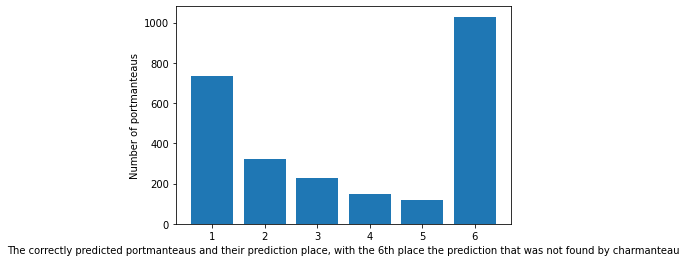

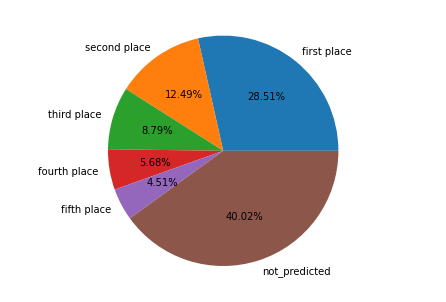

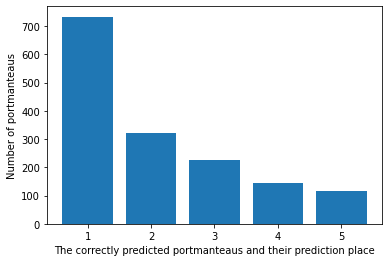

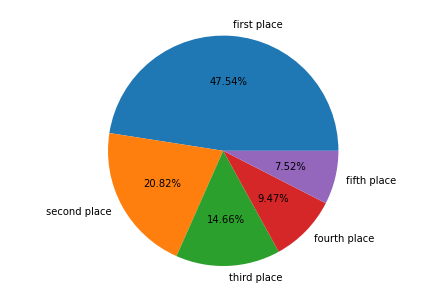

In [8]:
plot_charmanteau_performance(panda_charmanteau)

### Import portmanteau data of the simple generator

In [9]:
def all_correct_portmanteaus(panda):
    true_ports_data = pd.DataFrame(columns= panda.columns)
    for index in range(len(indices)):
        if indices[index] == 1: 
            continue
        if indices[index] == 0:
            true_ports_data = true_ports_data.append(panda.iloc[index])
    return true_ports_data


In [10]:
true_ports_data = all_correct_portmanteaus(panda_charmanteau)
panda_simple, data, groups_simple, true_ports,correctly_predicted_simple = construct_groups_simple('../data/simple_generation_features.txt', 2973, true_ports_data)

In [11]:
def construct_labels(true_ports):
    labels_simple = []
    for i in range(len(data)):
        if data[i]['result'] in true_ports:
            labels_simple.append(1)
        else:
            labels_simple.append(0)
    return labels_simple

Construct a test set for the data of the simple algorithm corresponding to the test set for the Charmanteau data

In [12]:
def construct_test_set(group_doccano_char, test):
    p = 0
    i = 0
    for elem in group_doccano_char:
        x = test.loc[test['root1'] == panda_charmanteau['root1'][p]]
        y = x.loc[test['root2'] == panda_charmanteau['root2'][p]]
        final = y.loc[test['group'] == -1]
        if len(final)== 0:
            print (panda.loc[p])
        controle = final.index[0]
        for element in final.index:
            if controle != element:
                break
            test['group'][element] = panda_charmanteau['group'][p]
            controle = controle + 1
        i = i + 1
        p = p + elem

In [13]:
test_simple = panda_simple.copy()
test_simple['group'] = -1
construct_test_set(groups, test_simple)

panda_simple = panda_simple.drop("prediction_place",axis=1)
simple_data_to_use = panda_simple.drop(columns=['root1', 'root2', 'result','group'])
labels_simple = construct_labels(true_ports)

In [14]:
j = 0
group_simple_test = []
data_simple = []
simple_label = []
ports_to_check_test_simple = []
columns = simple_data_to_use.columns
for i in range(len(groups_simple)):
    if correctly_predicted_simple[i] == 1:
        elems = groups_simple[i]
        group_simple_test.append(elems)
        for k in range(elems):
            data_simple.append(simple_data_to_use.iloc[j + k])
            ports_to_check_test_simple.append(panda_simple['result'][j + k])
            simple_label.append(labels_simple[j + k])
            
    j = j + groups_simple[i]

data_simple = pd.DataFrame(data_simple, columns=columns)

### Processing data before ranking: constructing the training and test data.

In [15]:
training = data_to_use.drop(columns=['portmanteau','prediction_place'])
columns = training.columns
training = training.values.tolist()
labels = data_to_use['portmanteau']
predictions = data_to_use['prediction_place']
labels = labels.values.tolist()
predictions = predictions.values.tolist()

In [16]:
data_train = []
label_train = []
prediction_train = []
data_test = []
label_test = []
prediction_test = []
ports_to_check_train = []
ports_to_check_test = []
label_train_long = []
compare_generator_char = []
for index in range(len(indices)):
    if indices[index] == 1: 
        data_train.append(training[index])
        label_train.append(labels[index])
        label_train_long.append(training[index][-1])
        ports_to_check_train.append({'result':ports_to_use['result'][index], 'root1':ports_to_use['root1'][index], 'root2':ports_to_use['root2'][index],})
    if indices[index] == 0:
        data_test.append(training[index])
        label_test.append(labels[index])
        prediction_test.append(predictions[index])
        ports_to_check_test.append({'result':ports_to_use['result'][index], 'root1':ports_to_use['root1'][index], 'root2':ports_to_use['root2'][index],})
        compare_generator_char.append(panda_charmanteau.values.tolist()[index])
        
data_test = pd.DataFrame(data_test, columns=columns)
data_train = pd.DataFrame(data_train, columns=columns)

label_test = pd.DataFrame(label_test, columns = ['portmanteau'])
label_train = pd.DataFrame(label_train, columns = ['portmanteau'])

compare_generator_char = pd.DataFrame(compare_generator_char,columns=panda_charmanteau.columns)


#### Constructing a corresponding test set using portmanteau generated by the simple algorithm

In [17]:
compare_generator_simple = test_simple.loc[test_simple['group'].isin(compare_generator_char.group.unique())]

In [18]:
column_index = data_test.columns.get_loc('group')
group_train = []
group_test= []
correct_predictions_test =[]
cur_elem = 0
cur_group = -1
for i in range(len(data_test)):
    row = data_test.loc[i]
    if row['group'] == cur_group:
        cur_elem = cur_elem + 1
    else:
        if cur_elem != 0 :
            correct_predictions_test.append(correctly_predicted[int(cur_group)])
            group_test.append(cur_elem)
        cur_group = row['group']
        cur_elem = 1
correct_predictions_test.append(correctly_predicted[int(cur_group)])
group_test.append(cur_elem)
    
cur_elem = 0
cur_group = -1    
for i in range(len(data_train)):
    row = data_train.loc[i]
    if row['group'] == cur_group:
        cur_elem = cur_elem + 1
    else:
        cur_group = row['group']
        if cur_elem != 0 :
            group_train.append(cur_elem)
        cur_elem = 1
group_train.append(cur_elem)

In [19]:
data_test = data_test.drop(columns = ['group'])
data_train = data_train.drop(columns = ['group'])

### Helper functions in order to compare Charmanteau and the simple generator and their corresponding rankings

In [20]:
def prediction(group_prediction, index, check_test_group):
    portmanteau = group_prediction[index]
    sorted_prediction = sorted(group_prediction)
    y = np.where(group_prediction == sorted_prediction[-1])
    x = sorted_prediction[::-1].index(portmanteau)
    worst_case = len(sorted_prediction) - 1 - sorted_prediction.index(portmanteau)
    count = sorted_prediction.count(portmanteau)
    return x,worst_case

In [21]:
def performance_measure(y_labels, y_prediction_labels, group, ports_to_check_test):
    y_labels = y_labels['portmanteau'].values.tolist()
    predictions = [0,0,0,0,0,0]
    worst_case_prediction = [0,0,0,0,0,0]
    charmanteau = 0
    non_charmanteau = 0
    portmanteau = 0
    p = 0
    for i in range(len(group)):
        predicted,worst_case = prediction(y_prediction_labels[p:(p+group[i])], y_labels[p:(p+group[i])].index(1), ports_to_check_test[p:(p+group[i])])
        predictions[predicted] += 1
        worst_case_prediction[worst_case] += 1
        p = p + group[i]
        if correctly_predicted[i] == 1:
            charmanteau = charmanteau +1
        else:
            non_charmanteau = non_charmanteau + 1
        portmanteau +=1
    print("Charmanteau: ", charmanteau)
    print("Portmanteau: ", portmanteau)
    print("Non-charmanteau: ", non_charmanteau)
    
    return predictions,worst_case_prediction

In [22]:
def performance_measure_simple(y_labels, y_prediction_labels, group, ports_to_check_test):
    predictions = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    charmanteau = 0
    non_charmanteau = 0
    portmanteau = 0
    worst_case = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

    p = 0
    for i in range(len(group)):
        predicted,worst = prediction(y_prediction_labels[p:(p+group[i])], y_labels[p:(p+group[i])].index(1), ports_to_check_test[p:(p+group[i])])
        predictions[predicted] += 1
        p = p + group[i]
        worst_case[worst] += 1
        if correctly_predicted[i] == 1:
            charmanteau = charmanteau +1
        else:
            non_charmanteau = non_charmanteau + 1
        portmanteau +=1
    print("Charmanteau: ", charmanteau)
    print("Portmanteau: ", portmanteau)
    print("Non-charmanteau: ", non_charmanteau)
    
    return predictions,worst_case

In [23]:
def performance_measure_charmanteau(y_labels, y_prediction_labels, group, ports_to_check_test):
    y_labels = y_labels['portmanteau'].values.tolist()
    predictions = [0,0,0,0,0,0]
    worst_case = [0,0,0,0,0,0]
    p = 0
    print(len(group))
    print(len(correct_predictions_test))
    for i in range(len(group)):
        if correct_predictions_test[i] == 1:
            predicted,worst = prediction(y_prediction_labels[p:(p+group[i])],y_labels[p:(p+group[i])].index(1),ports_to_check_test[p:(p+group[i])] )
            predictions[predicted] += 1
            p = p + group[i]
            worst_case[worst] += 1

        else:
            p = p + group[i]
    return predictions,worst_case

In [24]:
def performance_measure_not_generated(y_labels, y_prediction_labels, group, ports_to_check_test):
    y_labels = y_labels['portmanteau'].values.tolist()
    predictions = [0,0,0,0,0,0]
    worst_case = [0,0,0,0,0,0]
    p = 0
    for i in range(len(group)):
        if correct_predictions_test[i] == 0:
            predicted,worst = prediction(y_prediction_labels[p:(p+group[i])], y_labels[p:(p+group[i])].index(1), ports_to_check_test[p:(p+group[i])])
            predictions[predicted] += 1
            worst_case[worst] += 1
        p = p + group[i]
    return predictions

In [25]:
def plot_donut(data, save_name):
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
    
    if len(data) == 5: 
        recipe = ["1st place",
                  "2nd place",
                  "3rd place",
                  "4th place",
                  "5th place",
                 ]
    else:
        recipe = ["1st place",
                  "2nd place",
                  "3rd place or worse",
                 ]
        data[2] = sum(data[2:])
        data = data[:3]

    wedges, texts,_ = ax.pie(data, wedgeprops=dict(width=0.6), startangle=-40, autopct='%1.2f%%',textprops={'fontsize': 12, 'weight':'bold'}, pctdistance=0.75)
    plt.setp(texts, fontweight=600)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw, size=12)

    #fig.savefig(save_name, dpi=300)
    plt.show()

In [26]:
def sort_and_compare(charmanteau, simple):
    list1 = sorted(charmanteau, reverse=True)
    list2 = sorted(simple, reverse=True) 
    return pairwise_comparison(list1, list2)

In [27]:
def pairwise_comparison(list1, list2):
    winning_algoritm = [] #0 stands for an ex eaquo, 1 stands for charmanteau, 2 stands for simple
    index1 = 0
    index2 = 0
    while index1 < (len(list1)) and index2 < (len(list2)):
        if list1[index1] > list2[index2]: #charmanteau won
            winning_algoritm.append(1)
            index1 += 1
        elif list1[index1] < list2[index2]: #simple won
            winning_algoritm.append(2)
            index2 += 1
        elif list1[index1] == list2[index2]: #a tie occured
            winning_algoritm.append(0)
            winning_algoritm.append(0)
            index1 += 1
            index2 += 1
    for x in range (index2,len(list2)):
        winning_algoritm.append(2)
    for x in range (index1,len(list1)):
        winning_algoritm.append(1)
    return winning_algoritm

In [28]:
def interpret_result(list_of_winning_algoritms):
    k = 0
    for elem in list_of_winning_algoritms:
        if len(elem) > k:
            k = len(elem)
    charmanteau_wins = [0] * k
    simple_wins = [0] * k
    ex_aequo = [0] * k
    for elem in list_of_winning_algoritms:
        for j in range(0,len(elem)):
            if elem[j] == 0:
                ex_aequo[j] += 1
            if elem[j] == 1:
                charmanteau_wins[j] += 1
            if elem[j] == 2:
                simple_wins[j] += 1
    print("Charmanteau wins:", charmanteau_wins)
    print("Simple wins:", simple_wins)
    print("Tie:", ex_aequo)
    return (charmanteau_wins, simple_wins, ex_aequo)

In [29]:
def compare_algoritms(rankModel, data1, data2, alldata1, alldata2, size):    
    data_test1 = alldata1.drop(['prediction_place','group','result','root1','root2','portmanteau'],axis=1)
    data_test2 = alldata2.drop(['prediction_place','group','result', 'root1','root2'],axis=1)
    
    xgbTest1 = DMatrix(data_test1)
    predicted_by_model1 = rankModel.predict(xgbTest1)
    
    xgbTest2 = DMatrix(data_test2)
    predicted_by_model2 = rankModel.predict(xgbTest2)
    
    results = []
    for x in data1.group.unique():
        intermediate = data1.loc[data1['group'] == x]
        char_index = intermediate.loc[intermediate['prediction_place'] != 0]
        simple_index = data2.loc[data2['group'] == x]
        char_predictions = []
        simple_predictions = []
        for elem in char_index.index:
            char_predictions.append(predicted_by_model1[elem])
        
        for elem in simple_index.index:
            simple_predictions.append(predicted_by_model2[elem])
        
        winning_algoritm = sort_and_compare(char_predictions, simple_predictions)
        results.append(winning_algoritm)
    return interpret_result(results)
    

# Part 2: Ranking the portmanteaus using XGBoost pairwise ranking

### Training the model

In [30]:
xgb_params ={    
    'booster' : 'gbtree',
    'eta': 0.1,
    'gamma' : 1.0 ,
    'min_child_weight' : 0.1,
    'objective' : 'rank:pairwise',
    'eval_metric' : 'merror',
    #'num_class': 3,  # 
    'max_depth' : 6,
    'num_round' : 4,
    'save_period' : 0 
}

In [31]:
xgbTrain = DMatrix(data_train, label = label_train)
xgbTrain.set_group(group_train)

xgbTest = DMatrix(data_test)
xgbTest.set_group(group_test)
#evallist  = [(xgbTrain_eval, 'eval')]

In [32]:
rankModel = xgb.train(params=xgb_params,dtrain=xgbTrain  )
predicted_by_model = rankModel.predict(xgbTest)


[11:16:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_round, save_period } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## Ranking the generated portmanteaus of the two algoritms in respect to each other

In [33]:
#Comparing both algoritms using the learned ranking model
(charmanteau_wins, simple_wins, ex_aequo) = compare_algoritms(rankModel, compare_generator_char, compare_generator_simple, panda_charmanteau, test_simple, len(compare_generator_char.group.unique())) 


Charmanteau wins: [307, 296, 336, 321, 309, 287, 229, 216, 199, 212, 172, 139, 93, 58, 26, 17, 16, 3, 6, 1, 3]
Simple wins: [402, 351, 319, 341, 343, 367, 413, 444, 490, 475, 445, 352, 252, 166, 115, 72, 46, 33, 17, 10, 2]
Tie: [63, 125, 117, 110, 120, 118, 130, 112, 83, 81, 68, 49, 22, 13, 8, 4, 2, 1, 1, 1, 0]


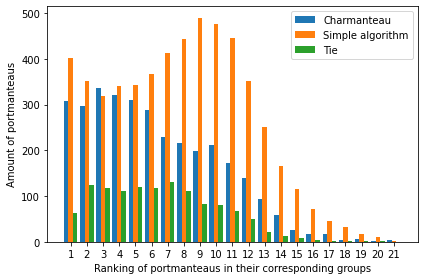

In [34]:
labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

x = np.arange(len(labels))  # the label locations
width = 0.28  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, charmanteau_wins, width, label='Charmanteau')
rects3 = ax.bar(x, simple_wins, width, label='Simple algorithm')
rects2 = ax.bar(x + width, ex_aequo, width, label='Tie')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylabel('Amount of portmanteaus')
ax.set_xlabel('Ranking of portmanteaus in their corresponding groups')


fig.tight_layout()
plt.savefig("Rerendered comparison", format='pdf')
plt.show()

## Ranking generated portmanteaus and evaluating the final ranking of the correctly generated portmanteau in respect to the other generated portmanteaus

### Ranking portmanteaus generated by the Charmanteau algorithm

#### Using all test data

Charmanteau:  476
Portmanteau:  772
Non-charmanteau:  296


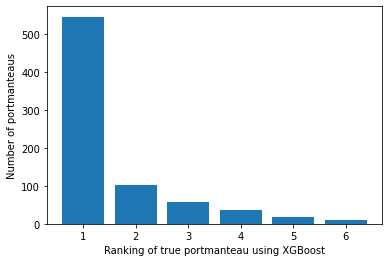

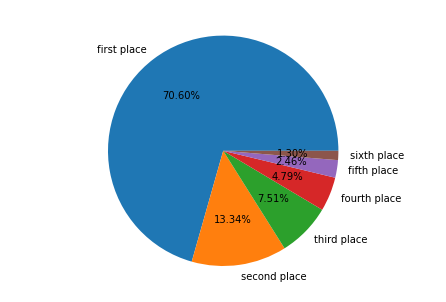

In [35]:
best_predict,worst_predict= performance_measure(label_test, predicted_by_model , group_test, ports_to_check_test)
plt.bar(x = [1,2,3,4,5,6], height= best_predict)
plt.xlabel('Ranking of true portmanteau using XGBoost')
plt.ylabel('Number of portmanteaus')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['first place', 'second place', 'third place', 'fourth place', 'fifth place','sixth place']
ax.pie(best_predict, labels = langs,autopct='%1.2f%%')
plt.show()

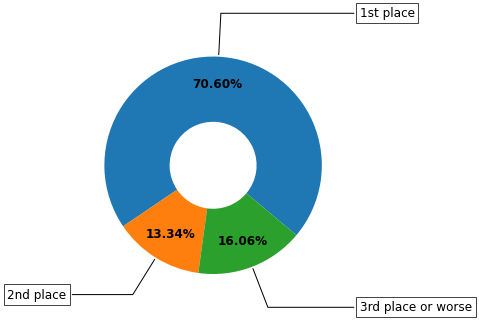

In [36]:
title = "All data"
save_name = "all_data_ranked.jpg"
plot_donut(best_predict, save_name)

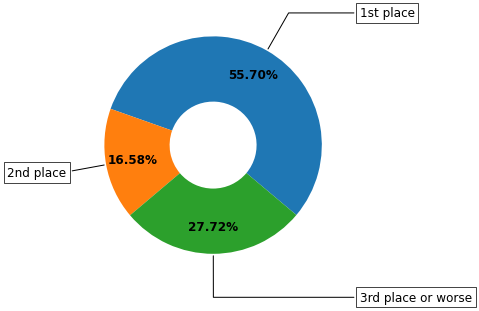

In [37]:
title = "All data worst prediction"
save_name = "all_data_ranked_worst.jpg"
plot_donut(worst_predict, save_name)

#### Using only the test data that contain only 5 portmanteaus (where Charmanteau is able to generated the portmanteau in question)

772
772


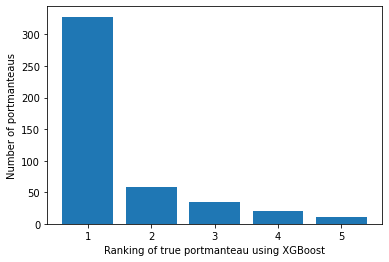

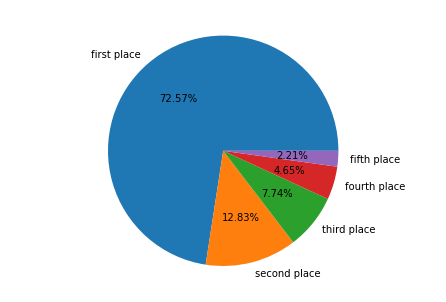

In [38]:
best,worst= performance_measure_charmanteau(label_test, predicted_by_model , group_test, ports_to_check_test)
plt.bar(x = [1,2,3,4,5], height= best[:5])
plt.xlabel('Ranking of true portmanteau using XGBoost')
plt.ylabel('Number of portmanteaus')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['first place', 'second place', 'third place', 'fourth place', 'fifth place']
ax.pie(best[:5], labels = langs,autopct='%1.2f%%')
plt.show()

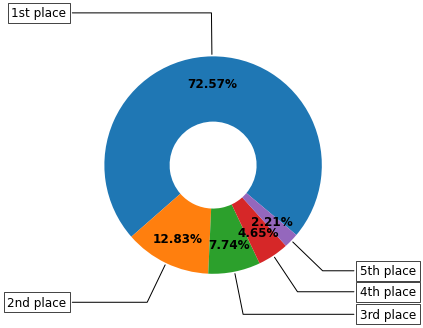

In [39]:
title = "The prediction of the data after adding the ranker best case"
save_name = "after_ranker.jpg"
plot_donut(best[:5],save_name)

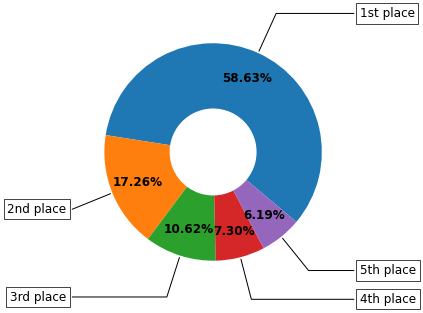

In [40]:
title = "The prediction of the data after adding the ranker worst case"
save_name = "after_ranker_worst.jpg"
plot_donut(worst[:5],save_name)

#### Using only the portmanteau groups where Charmanteau is not able to generate the correct portmanteau

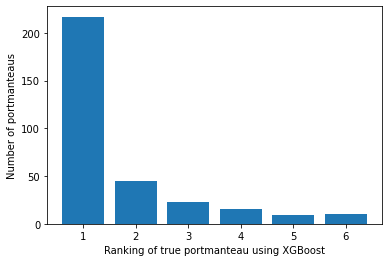

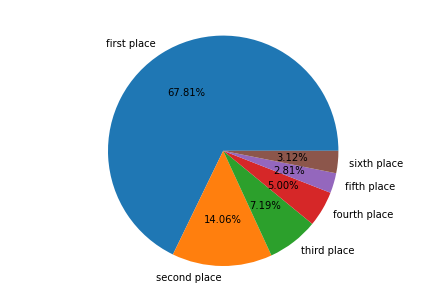

In [41]:
predict= performance_measure_not_generated(label_test, predicted_by_model , group_test, ports_to_check_test)
plt.bar(x = [1,2,3,4,5,6], height= predict[:])
plt.xlabel('Ranking of true portmanteau using XGBoost')
plt.ylabel('Number of portmanteaus')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['first place', 'second place', 'third place', 'fourth place', 'fifth place','sixth place']
ax.pie(predict[:], labels = langs,autopct='%1.2f%%')
plt.show()

### Ranking the simple algorithm data with the same ranker

Charmanteau:  302
Portmanteau:  496
Non-charmanteau:  194


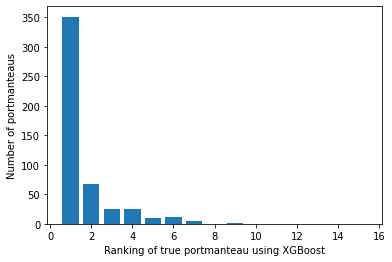

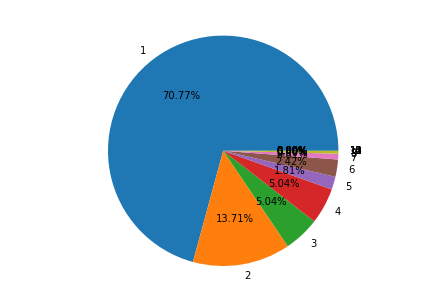

In [42]:
xgbTest = DMatrix(data_simple)
xgbTest.set_group(group_simple_test)
predicted_by_model = rankModel.predict(xgbTest)


best,worst= performance_measure_simple(simple_label, predicted_by_model , group_simple_test, ports_to_check_test_simple)
plt.bar(x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], height= best)
plt.xlabel('Ranking of true portmanteau using XGBoost')
plt.ylabel('Number of portmanteaus')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ax.pie(best, labels = langs,autopct='%1.2f%%')
plt.show()

#### Ranker in best case when ranking data generated by the simple algorithm

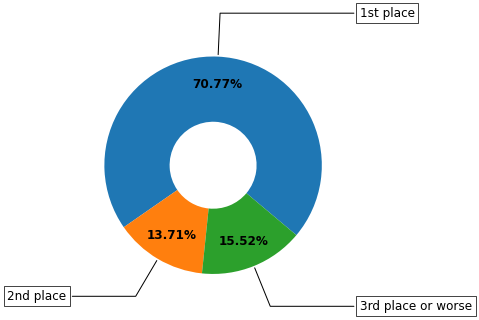

In [43]:
save_name = "simple_ranked.jpg"
plot_donut(best,save_name)

#### Ranker in worst case when ranking data generated by the simple algorithm

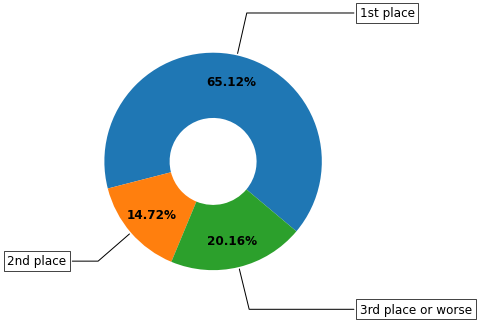

In [44]:
save_name = "simple_ranked_worst.jpg"
plot_donut(worst,save_name)